In [1]:
import time
import pandas as pd
import numpy as np
import re
import random
from pprint import pprint
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from clustering.sbd import sbd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

## Parameters ###################################################
DATA_FILE = "../data/20200831_user-db_cpu-load_02.json"
#DATA_FILE = "../data/20200901_user-db_network-latency_01.json"
TARGET_DATA = {"containers": "all",
               "services": "all",
               #"nodes": "all",
               "middlewares": "all"}
PLOTS_NUM = 360
SIGNIFICANCE_LEVEL = 0.05
THRESHOLD_DIST = 0.01
#################################################################

# Prepare data matrix
raw_data = pd.read_json(DATA_FILE)
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target] or TARGET_DATA[target] == "all":
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1]) if target != "middlewares" else "container_name"].replace("gke-microservices-experi-default-pool-", "")
                if re.match("^gke-microservices-experi", target_name):
                    continue
                if target_name in ["queue-master", "rabbitmq", "session-db"]:
                    continue
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
data_df = data_df.round(4)
# Thin out data
#data_df = data_df.query('index % 2 == 0')
#

# Prepare target list
containers_list = []
services_list = []
nodes_list = []
middlewares_list = []
for col in data_df.columns:
    if re.match("^c-", col):
        container_name = col.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", col):
        service_name = col.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
    elif re.match("^n-", col):
        node_name = col.split("_")[0].replace("n-", "")
        if node_name not in nodes_list:
            nodes_list.append(node_name)
    elif re.match("^m-", col):
        middleware_name = col.split("_")[0].replace("m-", "")
        if middleware_name not in middlewares_list:
            middlewares_list.append(middleware_name)
            
# Aggregate the dimension of a metric
metrics_dimension = {}
for target in TARGET_DATA:
    metrics_dimension[target] = {}

def count_metrics(metrics_dimension, dataframe, n):
    for col in dataframe.columns:
        if re.match("^c-", col):
            container_name = col.split("_")[0].replace("c-", "")   
            if container_name not in metrics_dimension["containers"]:
                metrics_dimension["containers"][container_name] = [0,0,0]        
            metrics_dimension["containers"][container_name][n] += 1
        elif re.match("^m-", col):
            middleware_name = col.split("_")[0].replace("m-", "")    
            if middleware_name not in metrics_dimension["middlewares"]:
                metrics_dimension["middlewares"][middleware_name] = [0,0,0]
            metrics_dimension["middlewares"][middleware_name][n] += 1
        elif re.match("^s-", col):
            service_name = col.split("_")[0].replace("s-", "")
            if service_name not in metrics_dimension["services"]:
                metrics_dimension["services"][service_name] = [0,0,0]
            metrics_dimension["services"][service_name][n] += 1
        elif re.match("^n-", col):
            node_name = col.split("_")[0].replace("n-", "")
            if node_name not in metrics_dimension["nodes"]:
                metrics_dimension["nodes"][node_name] = [0,0,0]
            metrics_dimension["nodes"][node_name][n] += 1
    return metrics_dimension

# DTW
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

metrics_dimension = count_metrics(metrics_dimension, data_df, 0)
metrics_dimension["total"] = [len(data_df.columns)]
pprint(metrics_dimension)

{'containers': {'carts': [55, 0, 0],
                'carts-db': [55, 0, 0],
                'catalogue': [55, 0, 0],
                'catalogue-db': [51, 0, 0],
                'front-end': [55, 0, 0],
                'orders': [55, 0, 0],
                'orders-db': [55, 0, 0],
                'payment': [55, 0, 0],
                'shipping': [55, 0, 0],
                'user': [55, 0, 0],
                'user-db': [55, 0, 0]},
 'middlewares': {'carts-db': [124, 0, 0],
                 'catalogue-db': [555, 0, 0],
                 'orders-db': [124, 0, 0],
                 'user-db': [127, 0, 0]},
 'services': {'carts': [2, 0, 0],
              'catalogue': [2, 0, 0],
              'front-end': [2, 0, 0],
              'orders': [2, 0, 0],
              'payment': [2, 0, 0],
              'shipping': [2, 0, 0],
              'user': [2, 0, 0]},
 'total': [1545]}


In [2]:
# Reduce metrics
## Step 1: Reduced metrics with stationarity
start = time.time()
reduced_by_st_df = pd.DataFrame()
for col in data_df.columns:
    data = data_df[col].values
    if data.sum() == 0. or len(np.unique(data)) == 1 or np.isnan(data.sum()):
        p_val = np.nan
    else:
        p_val = adfuller(data)[1]
    if not np.isnan(p_val):
        if p_val >= SIGNIFICANCE_LEVEL:
            reduced_by_st_df[col] = data_df[col]


metrics_dimension = count_metrics(metrics_dimension, reduced_by_st_df, 1)
metrics_dimension["total"].append(len(reduced_by_st_df.columns))
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")
pprint(metrics_dimension)

/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Elapsed time:3.322/sec
{'containers': {'carts': [55, 10, 0],
                'carts-db': [55, 9, 0],
                'catalogue': [55, 9, 0],
                'catalogue-db': [51, 6, 0],
                'front-end': [55, 6, 0],
                'orders': [55, 6, 0],
                'orders-db': [55, 9, 0],
                'payment': [55, 4, 0],
                'shipping': [55, 7, 0],
                'user': [55, 7, 0],
                'user-db': [55, 13, 0]},
 'middlewares': {'carts-db': [124, 27, 0],
                 'catalogue-db': [555, 27, 0],
                 'orders-db': [124, 24, 0],
                 'user-db': [127, 20, 0]},
 'services': {'carts': [2, 1, 0],
              'catalogue': [2, 2, 0],
              'front-end': [2, 2, 0],
              'orders': [2, 2, 0],
              'payment': [2, 1, 0],
              'shipping': [2, 2, 0],
              'user': [2, 2, 0]},
 'total': [1545, 196]}


In [3]:
## Step 2: Reduced by hierarchical clustering
#
#distance_list = []
#
def hierarchical_clustering(target_df, clustering_info, dist_func):
    series = target_df.values.T
    norm_series = z_normalization(series)
    dist = pdist(norm_series, metric=dist_func)
    #distance_list.extend(dist)
    dist_matrix = squareform(dist)
    z = linkage(dist, method="single", metric=dist_func)
    labels = fcluster(z, t=THRESHOLD_DIST, criterion="distance")
    cluster_dict = {}
    for i, v in enumerate(labels):
        if v not in cluster_dict:
            cluster_dict[v] = [i]
        else:
            cluster_dict[v].append(i)
    remove_list = []
    for c in cluster_dict:
        cluster_metrics = cluster_dict[c]
        if len(cluster_metrics) == 1:
            continue
        if len(cluster_metrics) == 2:
            # Select the representative metric at random
            shuffle_list = random.sample(cluster_metrics, len(cluster_metrics))
            clustering_info[target_df.columns[shuffle_list[0]]] = [target_df.columns[shuffle_list[1]]]
            remove_list.append(target_df.columns[shuffle_list[1]])
        elif len(cluster_metrics) > 2:
            # Select medoid as the representative metric
            distances = []
            for met1 in cluster_metrics:
                dist_sum = 0
                for met2 in cluster_metrics:
                    if met1 != met2:
                        dist_sum += dist_matrix[met1][met2]
                distances.append(dist_sum)
            medoid = cluster_metrics[np.argmin(distances)]
            clustering_info[target_df.columns[medoid]] = []
            for r in cluster_metrics:
                if r != medoid:
                    remove_list.append(target_df.columns[r])
                    clustering_info[target_df.columns[medoid]].append(target_df.columns[r])                 
    return clustering_info, remove_list

def z_normalization(data):
    arr = []
    for d in data:
        mean = d.mean()
        std = d.std()
        arr.append((d - mean) / std)
    return np.array(arr)

start = time.time()
clustering_info = {}
reduced_df = reduced_by_st_df

# Clustering metrics by service including services, containers and middlewares metrics
for ser in services_list:
    target_df = reduced_by_st_df.loc[:, reduced_by_st_df.columns.str.startswith(("s-{}_".format(ser), "c-{}".format(ser), "m-{}".format(ser)))]
    if len(target_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = hierarchical_clustering(target_df, clustering_info, sbd)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)
        
metrics_dimension = count_metrics(metrics_dimension, reduced_df, 2)
metrics_dimension["total"].append(len(reduced_df.columns))
print("Elapsed time:{:.3f}".format(time.time() - start) + "/sec")
pprint(metrics_dimension)

Elapsed time:0.348/sec
{'containers': {'carts': [55, 10, 7],
                'carts-db': [55, 9, 6],
                'catalogue': [55, 9, 4],
                'catalogue-db': [51, 6, 5],
                'front-end': [55, 6, 4],
                'orders': [55, 6, 5],
                'orders-db': [55, 9, 6],
                'payment': [55, 4, 3],
                'shipping': [55, 7, 5],
                'user': [55, 7, 6],
                'user-db': [55, 13, 7]},
 'middlewares': {'carts-db': [124, 27, 16],
                 'catalogue-db': [555, 27, 9],
                 'orders-db': [124, 24, 16],
                 'user-db': [127, 20, 12]},
 'services': {'carts': [2, 1, 1],
              'catalogue': [2, 2, 1],
              'front-end': [2, 2, 2],
              'orders': [2, 2, 1],
              'payment': [2, 1, 1],
              'shipping': [2, 2, 2],
              'user': [2, 2, 0]},
 'total': [1545, 196, 119]}


In [49]:
print(len(clustering_info))
clustering_info

24


{'c-shipping_last_seen': ['c-shipping_fs_usage_bytes'],
 'c-shipping_memory_cache': ['c-shipping_memory_usage_bytes'],
 'c-orders-db_last_seen': ['c-orders-db_fs_usage_bytes',
  'c-orders-db_memory_cache',
  'c-orders-db_memory_usage_bytes',
  'c-orders_last_seen',
  'm-orders-db_mongodb_mongod_op_latencies_ops_total',
  'm-orders-db_mongodb_mongod_op_latencies_latency_total',
  'm-orders-db_mongodb_mongod_op_latencies_histogram',
  'm-orders-db_mongodb_instance_local_time',
  'm-orders-db_go_memstats_last_gc_time_seconds'],
 'm-orders-db_mongodb_mongod_metrics_document_total': ['s-orders_throughput',
  'm-orders-db_mongodb_mongod_wiredtiger_log_records_total',
  'm-orders-db_mongodb_mongod_wiredtiger_transactions_total'],
 'm-orders-db_mongodb_op_counters_total': ['m-orders-db_mongodb_network_metrics_num_requests_total'],
 'c-carts_memory_usage_bytes': ['c-carts_memory_working_set_bytes'],
 'c-carts_network_transmit_packets_total': ['c-carts_network_transmit_bytes_total',
  'c-carts_n

In [77]:
import os


'./results/file.py'

# 可視化

In [50]:
# 正規化
normalized_df = pd.DataFrame()
for column in data_df.columns:
    data = data_df[column].values
    norm_const = data.mean()
    #norm_const = data.max()
    if norm_const == 0. :
        continue    
    normalized_df[column] = data_df[column] / norm_const

In [51]:
normalized_df

,c-orders-db_cpu_system_seconds_total,c-orders-db_fs_writes_bytes_total,c-orders-db_start_time_seconds,c-orders-db_spec_cpu_period,c-orders-db_fs_usage_bytes,c-orders-db_cpu_user_seconds_total,c-orders-db_memory_cache,c-orders-db_memory_usage_bytes,c-orders-db_fs_writes_total,c-orders-db_spec_cpu_quota,...,m-user-db_mongodb_mongod_wiredtiger_transactions_total,m-user-db_mongodb_mongod_wiredtiger_concurrent_transactions_available_tickets,m-user-db_go_memstats_alloc_bytes,m-user-db_go_memstats_mspan_inuse_bytes,m-user-db_go_memstats_stack_sys_bytes,m-user-db_go_memstats_stack_inuse_bytes,m-user-db_mongodb_tcmalloc_cache_bytes,m-user-db_process_virtual_memory_bytes,m-user-db_mongodb_mongod_wiredtiger_cache_bytes_total,m-user-db_process_resident_memory_bytes
0,1.138103,1.051801,1.0,1.0,0.958598,0.943437,0.888699,0.961590,1.061919,1.0,...,1.013172,1.000119,0.721609,0.957155,1.012975,1.012975,0.999917,1.0,1.090913,1.0
1,1.138103,1.051801,1.0,1.0,0.958598,0.943437,0.888699,0.961590,1.061919,1.0,...,1.009831,1.000119,1.194632,0.986160,0.956698,0.956698,0.999823,1.0,1.090913,1.0
2,1.198003,1.134036,1.0,1.0,0.958598,0.974885,0.888699,0.961590,1.090941,1.0,...,1.010666,1.000119,0.624093,0.947487,0.956698,0.956698,0.999667,1.0,1.090913,1.0
3,1.198003,1.060563,1.0,1.0,0.958598,1.053505,0.888699,0.962105,1.064560,1.0,...,1.020168,1.000119,0.816415,0.947487,0.956698,0.956698,0.999915,1.0,1.090913,1.0
4,1.198003,1.060563,1.0,1.0,0.958598,1.053505,0.888699,0.962105,1.064560,1.0,...,1.017472,1.000119,1.289075,1.011942,1.069251,1.069251,0.999501,1.0,1.090913,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.898502,0.862680,1.0,1.0,1.040913,0.943437,1.107821,1.038049,0.802264,1.0,...,0.905105,1.000119,1.050849,0.999051,1.012975,1.012975,1.000231,1.0,1.090913,1.0
356,0.898502,0.862680,1.0,1.0,1.040913,0.943437,1.107821,1.038049,0.802264,1.0,...,0.893499,1.000119,1.242777,1.011942,1.012975,1.012975,1.000504,1.0,1.090913,1.0
357,0.958403,0.752212,1.0,1.0,1.040913,0.927713,1.107821,1.037780,0.808249,1.0,...,0.884535,1.000119,0.675617,0.976492,1.012975,1.012975,1.000148,1.0,1.090913,1.0
358,0.958403,0.752212,1.0,1.0,1.040913,0.927713,1.107821,1.037780,0.808249,1.0,...,0.890852,1.000119,1.160375,0.979715,0.956698,0.956698,1.000347,1.0,0.000000,1.0


/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


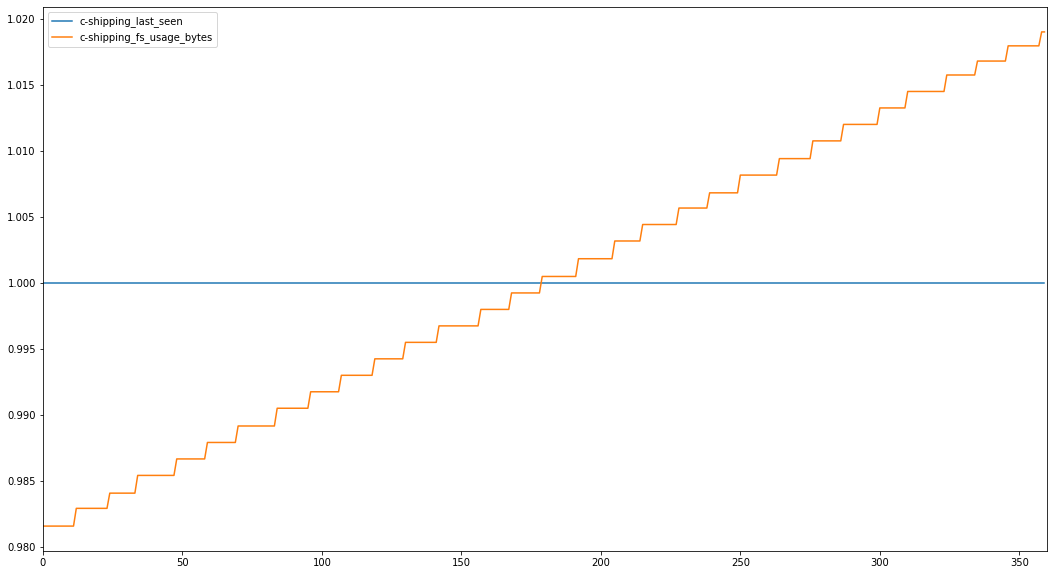

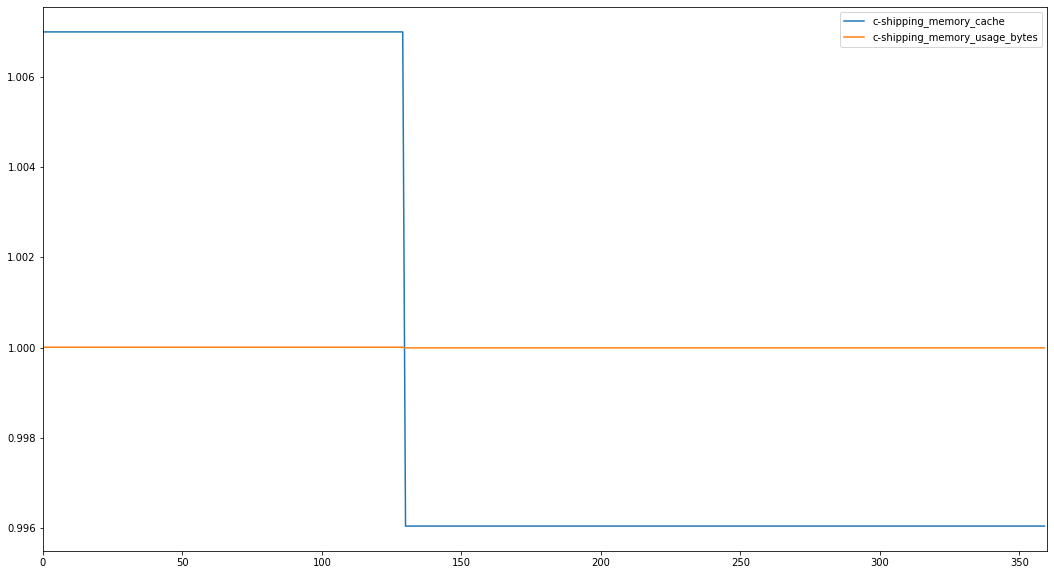

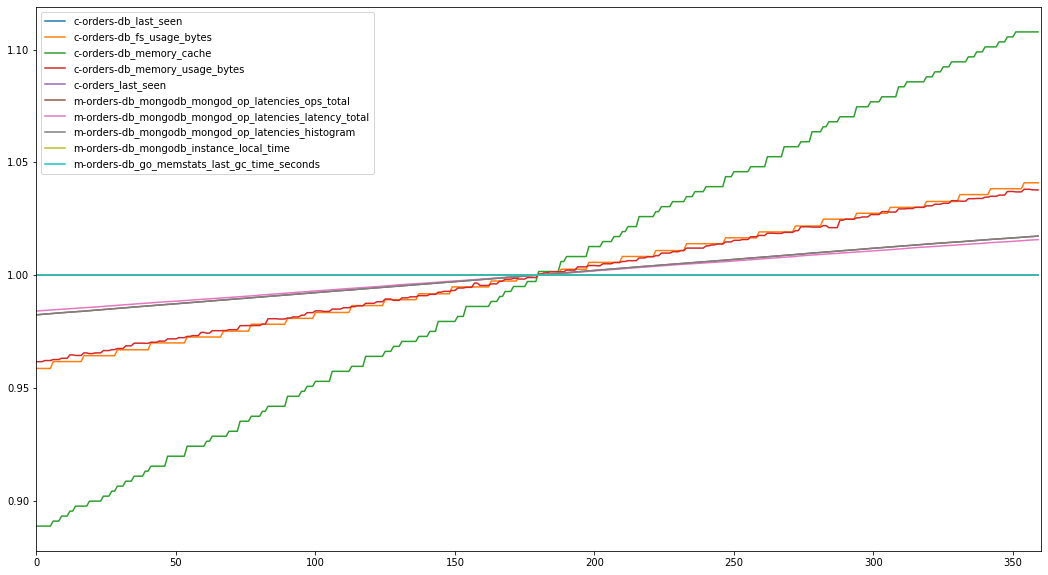

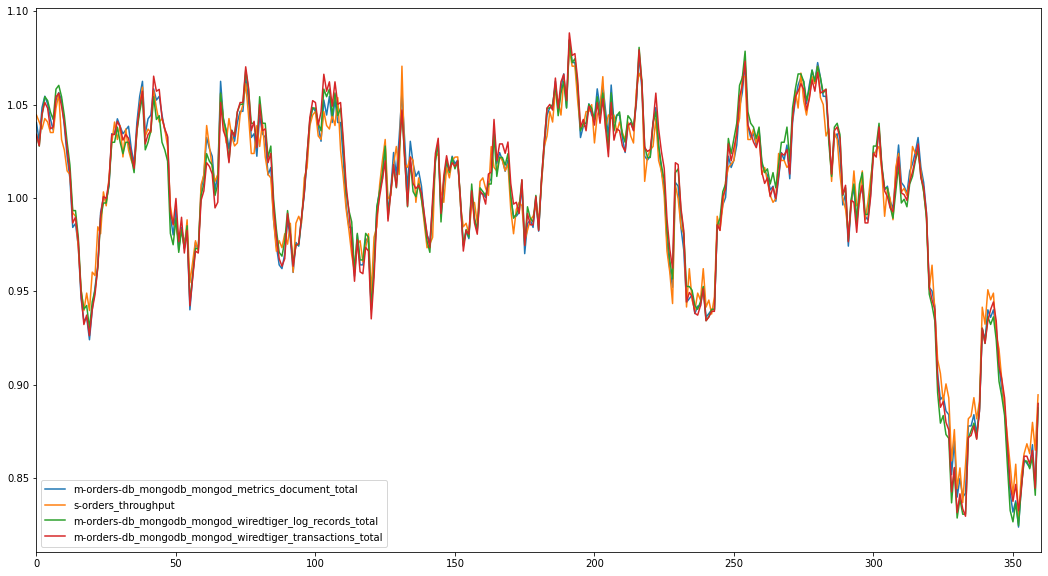

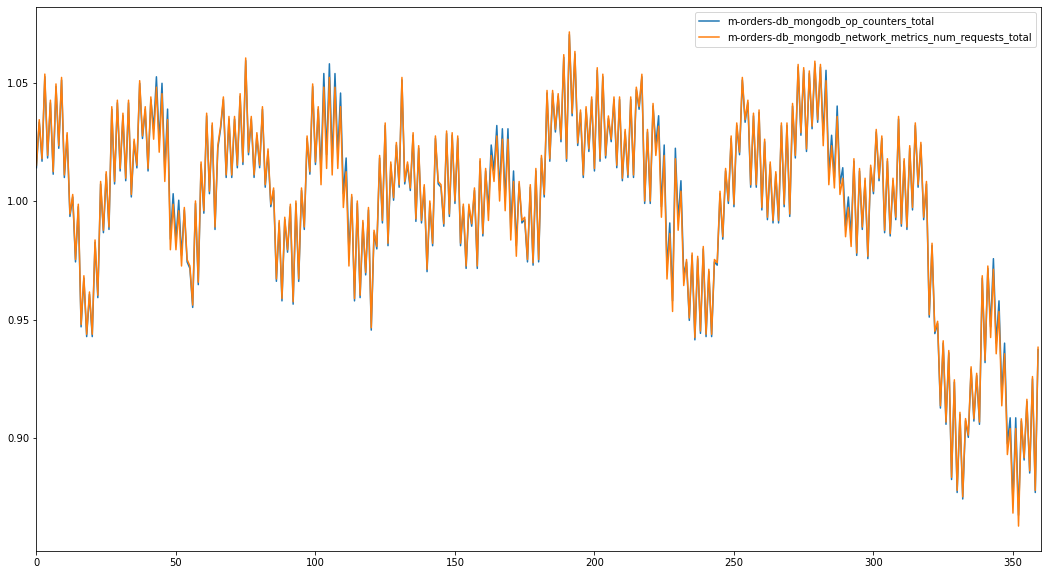

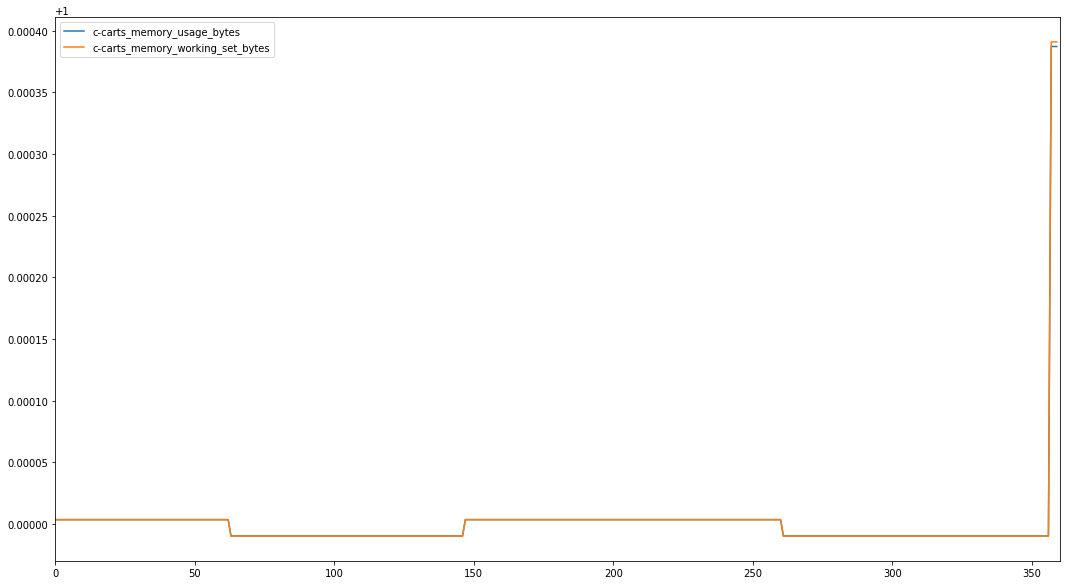

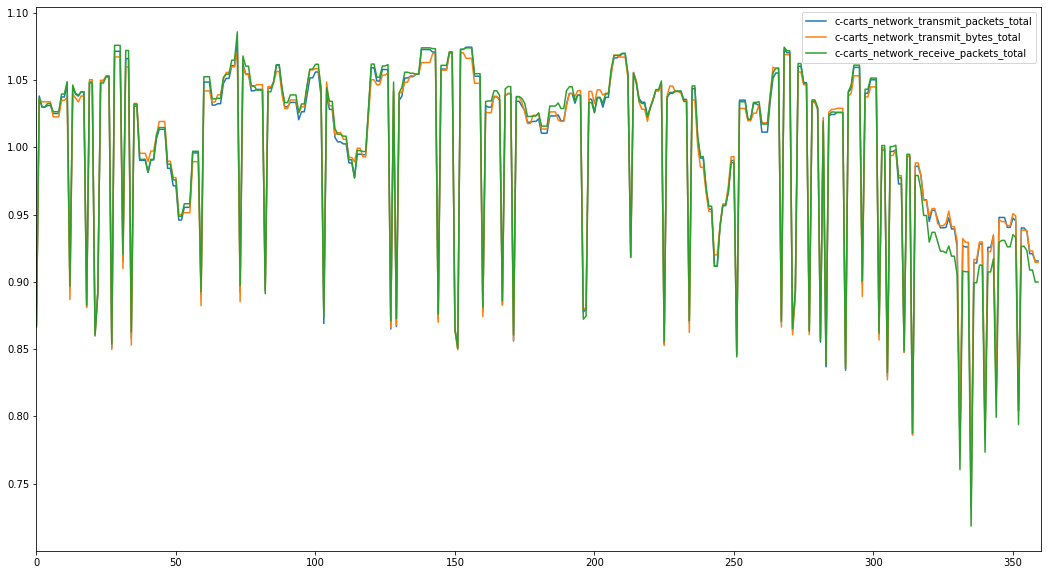

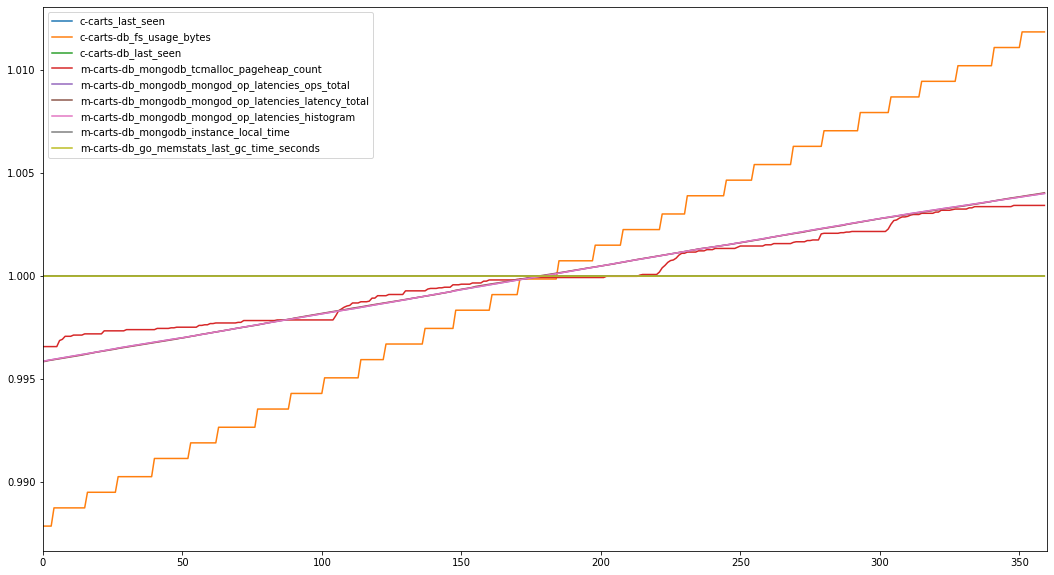

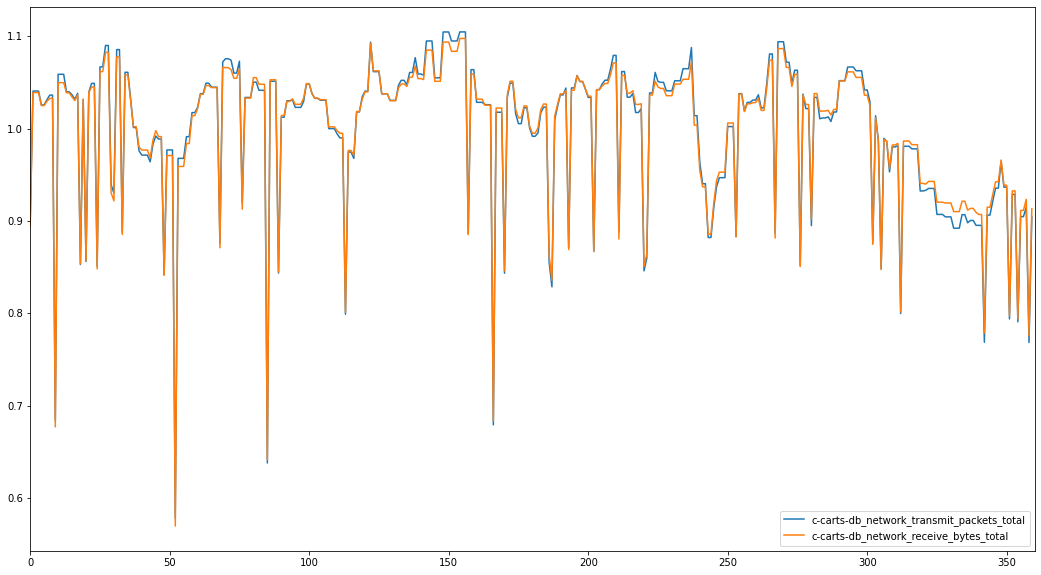

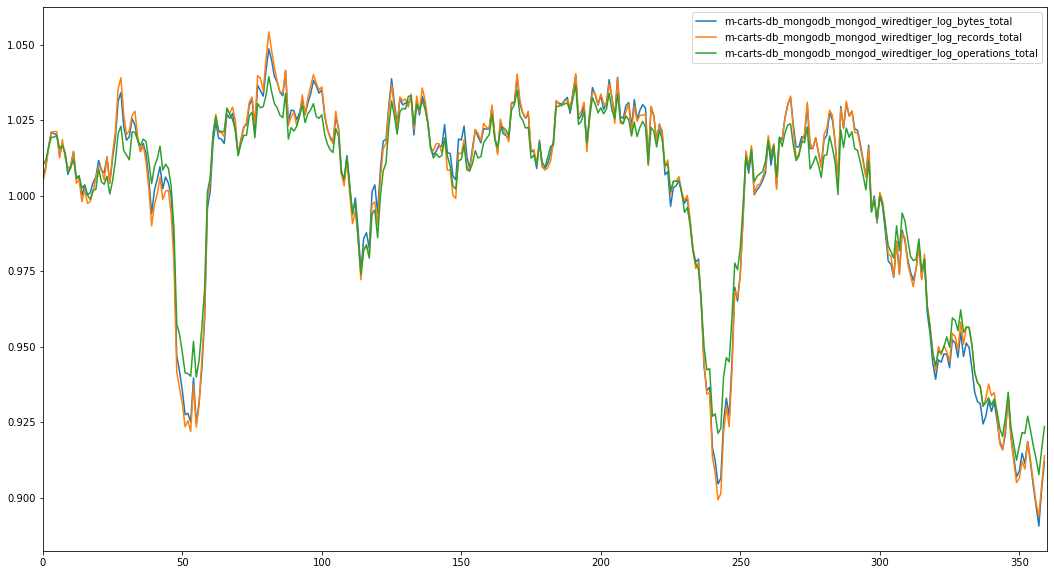

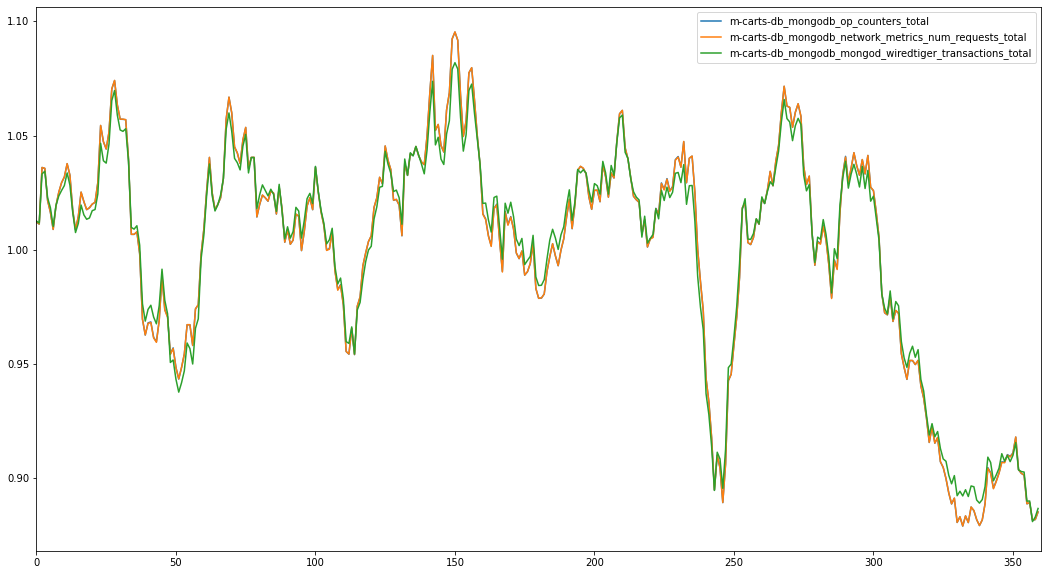

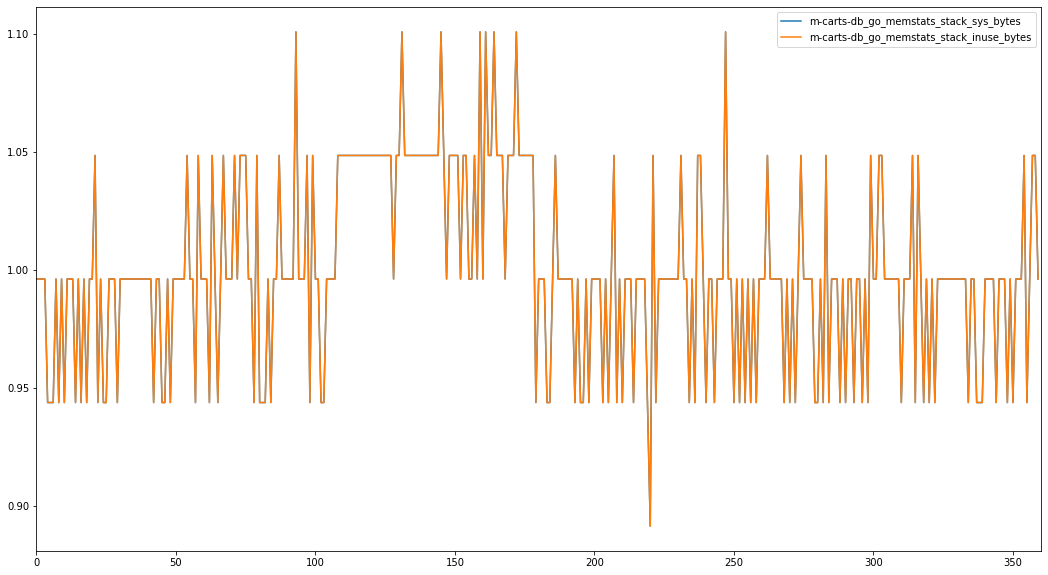

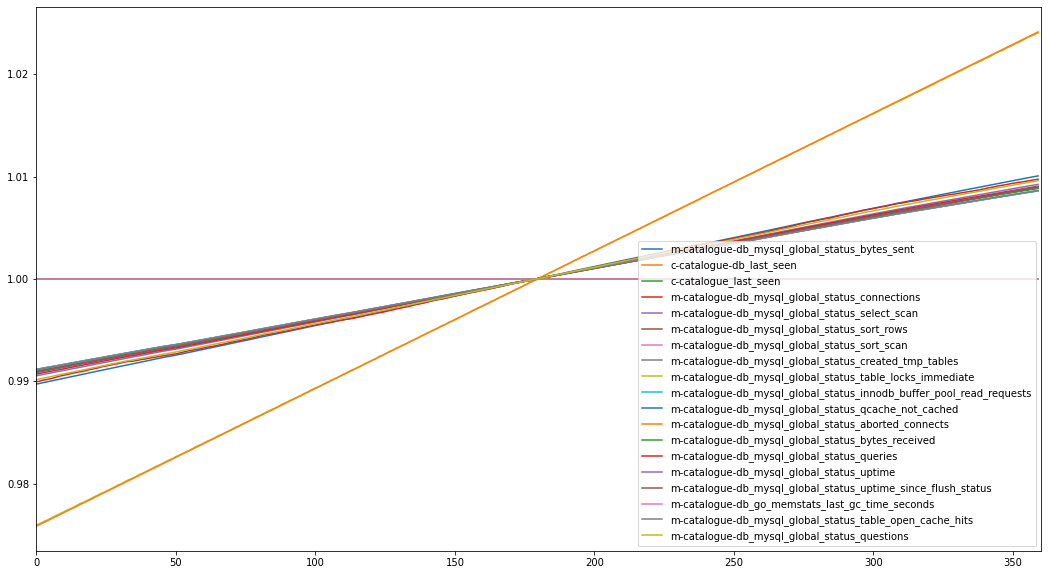

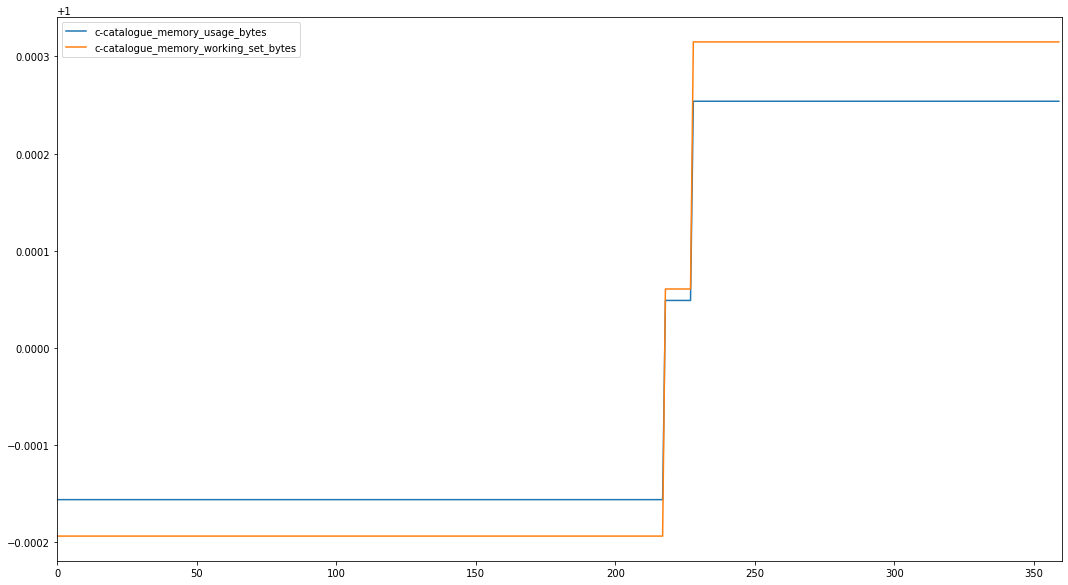

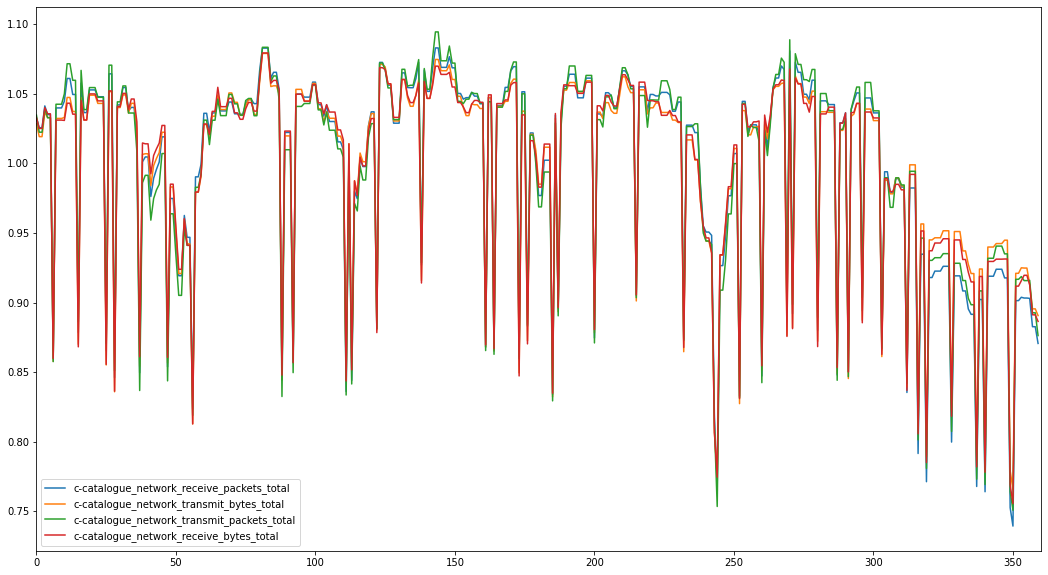

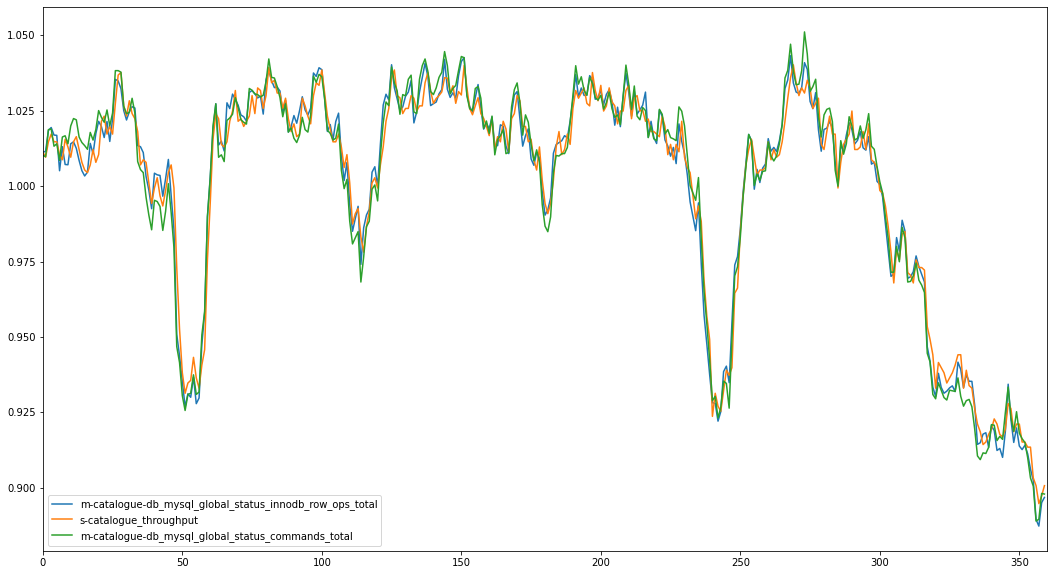

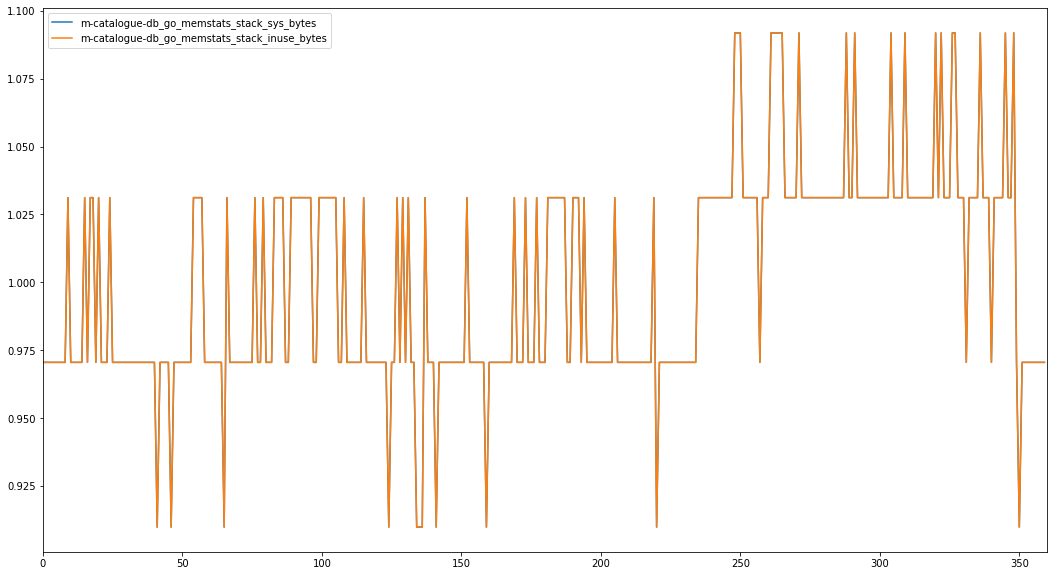

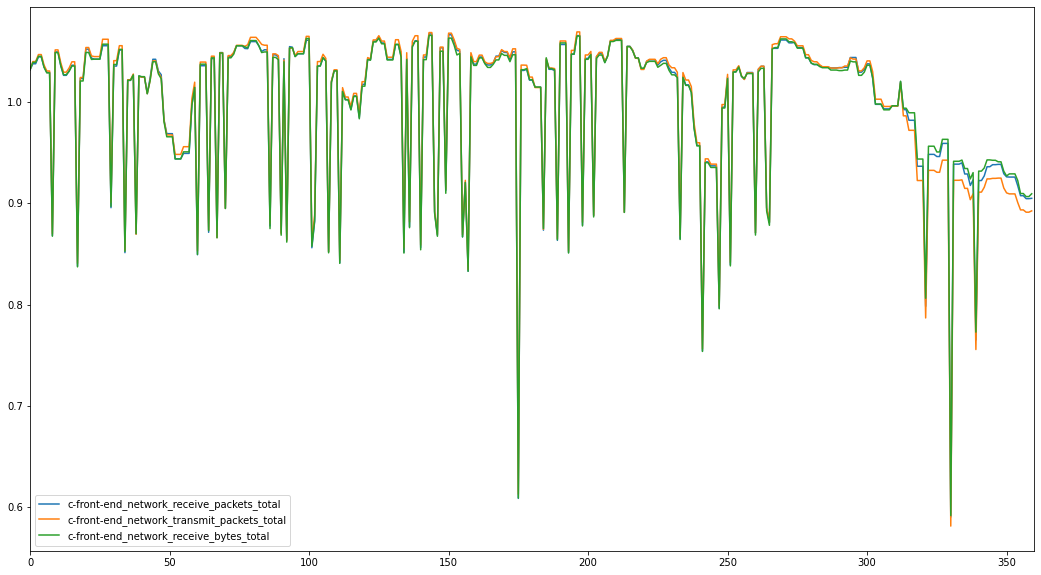

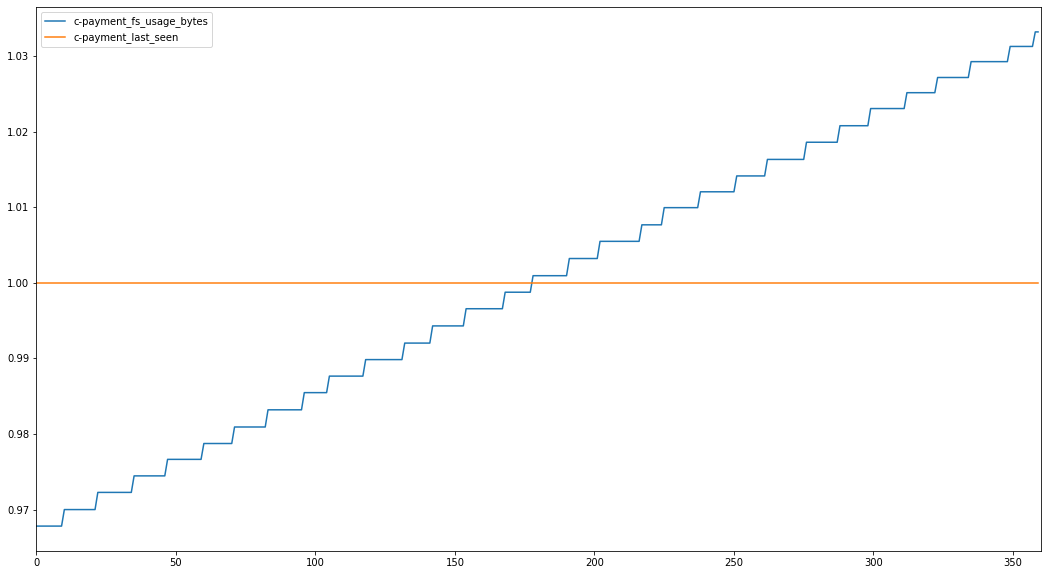

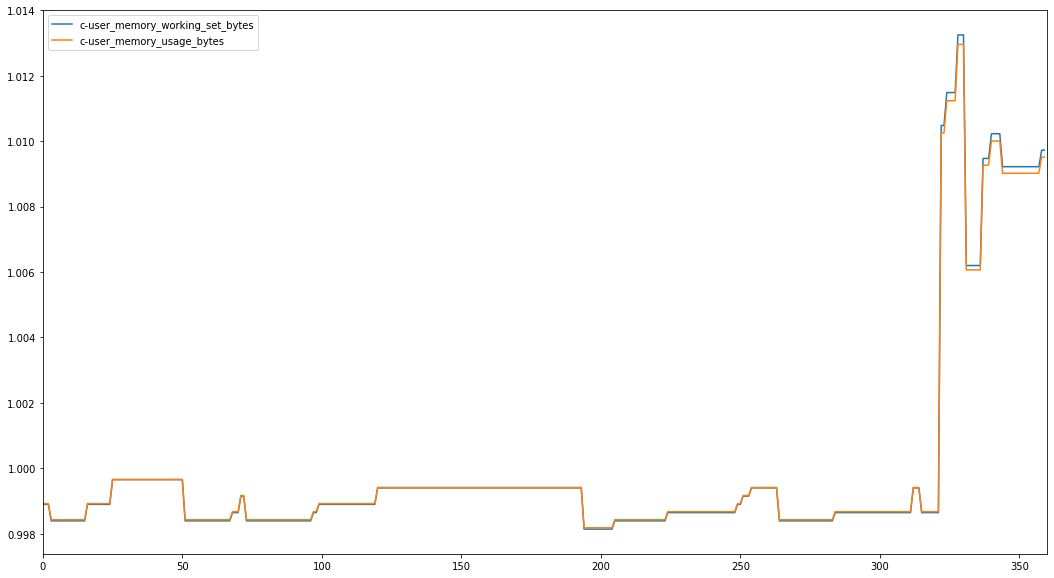

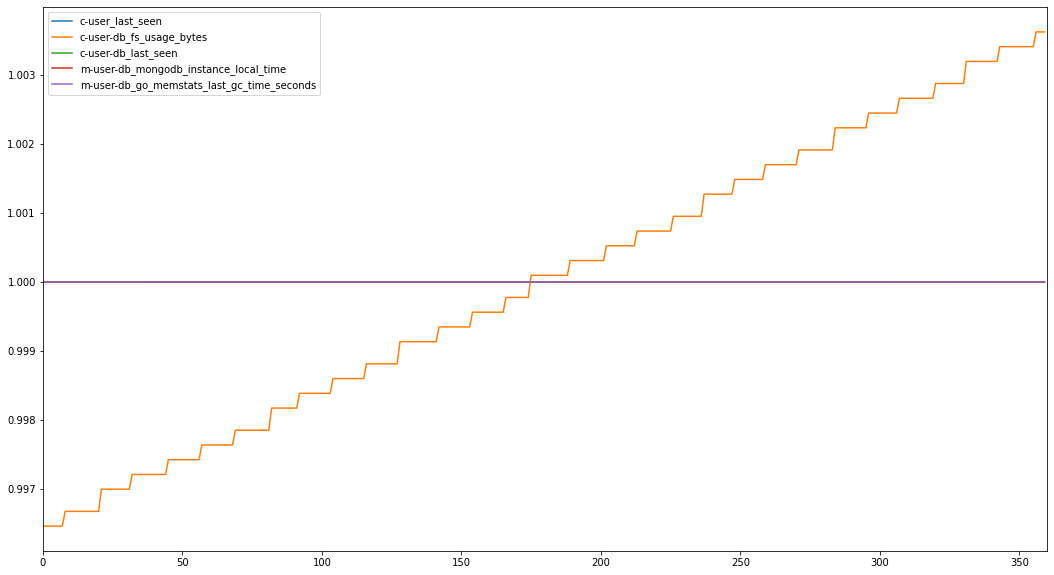

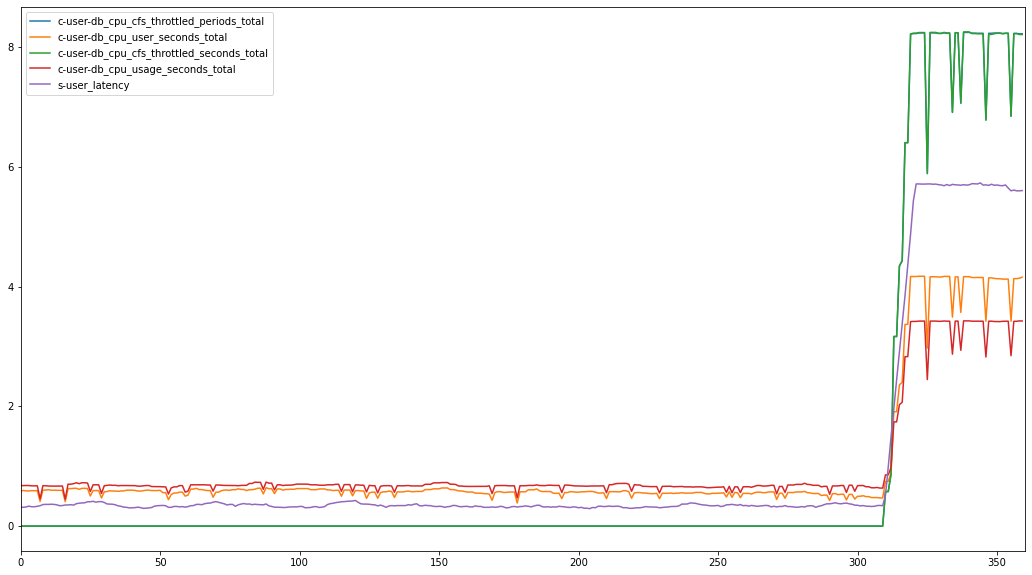

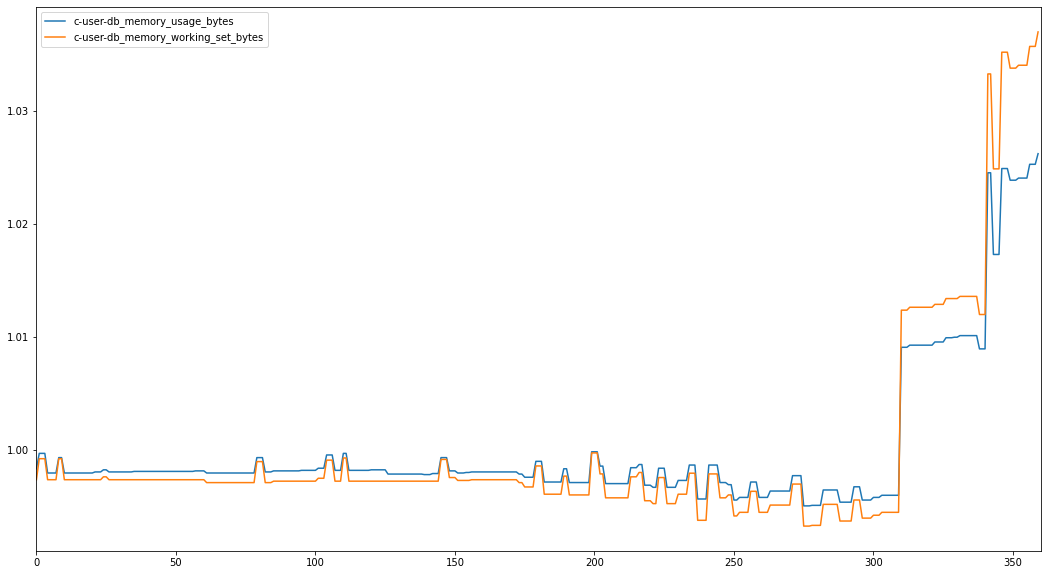

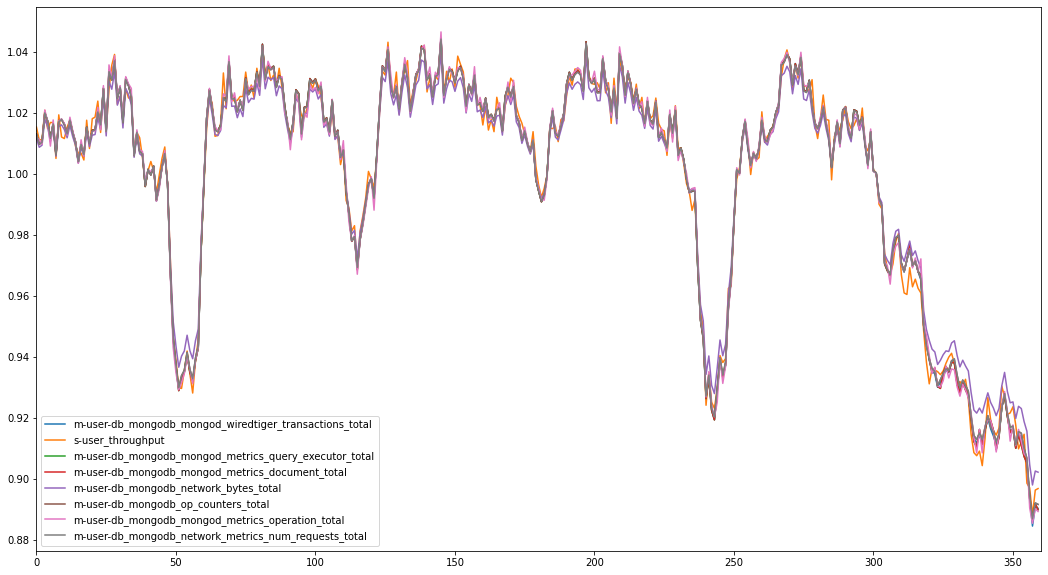

In [52]:
for medoid in clustering_info:
    metric_list = [medoid]
    metric_list.extend(clustering_info[medoid])
    df = pd.DataFrame()
    for m in metric_list:
        df[m] = normalized_df[m]
        #p_val = adfuller(normalized_df[m].values, regression="c")[1]#.round(4)
        #print("{}: {}".format(m, p_val))
    df.plot(figsize=(18, 10), xlim=[0,360])

c-user-db_cpu_user_seconds_total: 0.9476
c-user-db_cpu_usage_seconds_total: 0.9412


<AxesSubplot:>

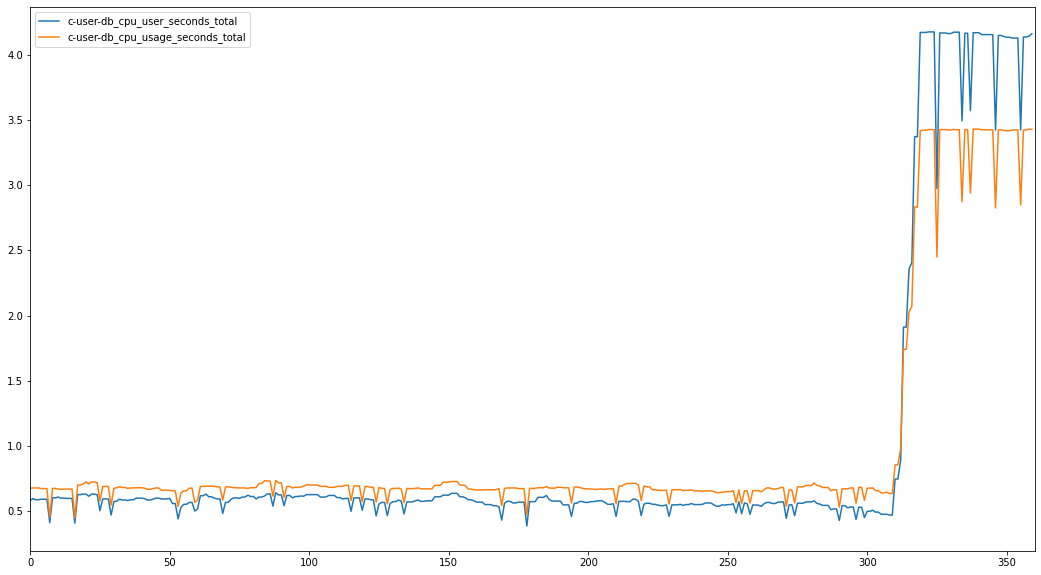

In [150]:
df = pd.DataFrame()
mets = ["c-user-db_cpu_user_seconds_total", "c-user-db_cpu_usage_seconds_total", "c-user-db_cpu_cfs_throttled_seconds_total"]
#"", "c-user-db_cpu_cfs_throttled_periods_total"

for m in mets:
    df[m] = normalized_df[m]
    print("{}: {}".format(m, adfuller(normalized_df[m].values, regression="c")[1].round(4)))
df.plot(figsize=(18, 10), xlim=[0,360])

In [11]:
x = data_df["c-user-db_cpu_user_seconds_total"].values
y = data_df["c-user-db_cpu_usage_seconds_total"].values
dtw(x, y)

4.119699999999999

# ADF検定
・p_valが有意水準より小さい → 単位根であるが棄却され定常過程 → 除外する

In [32]:
series = data_df["n-66a015a7-eq47_netstat_Tcp_ActiveOpens"].values
p_val = adfuller(series)[1]
p_val

0.9951406016965765

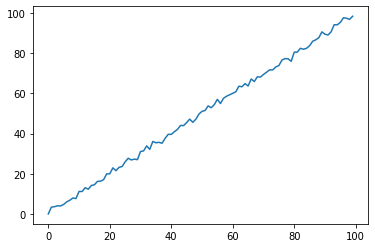

In [35]:
x = np.arange(100)
y = x + np.random.normal(0, 1, size=len(x))
plt.plot(x, y)

In [47]:
p_val = adfuller(y, regression="ct")[1]
p_val

0.010083844601438612

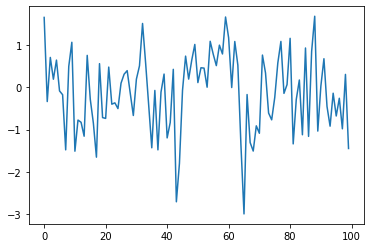

In [37]:
x = np.arange(100)
y = np.random.normal(0, 1, size=len(x))
plt.plot(x, y)

In [38]:
p_val = adfuller(y)[1]
p_val

0.0015421069285832644

In [7]:
import os
os.uname()[1]

'PC104110.local'